In [3]:
## LIBRERIAS
from google.colab import drive, files
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
from keras import Model, Sequential
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Rescaling, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import random
import os
random.seed(1234)

In [ ]:
## Cargamos Drive e importamos las imágenes de train y test
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/Sentinel2LULC_354.zip" -d "/content"
!unzip "/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/Sentinel2LULC_Test.zip" -d "/content"

In [ ]:
## Descargamos y descomprimimos los pesos "noisy student" más recientes
## de EfficientNetB1
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/advprop/efficientnet-b1.tar.gz
!tar -xf efficientnet-b1.tar.gz -C /content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle

--2022-03-14 18:53:05--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/advprop/efficientnet-b1.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 108.177.15.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57868007 (55M) [application/gzip]
Saving to: ‘efficientnet-b1.tar.gz’

efficientnet-b1.tar 100%[===================>]  55.19M  50.2MB/s    in 1.1s    

2022-03-14 18:53:06 (50.2 MB/s) - ‘efficientnet-b1.tar.gz’ saved [57868007/57868007]



In [ ]:
## Convertimos los pesos a formato h5
!python /content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/efficientnet_weight_update_util.py --model b1 --notop --ckpt \
        /content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/efficientnet-b1/model.ckpt --o /content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/efficientnetb1_notop.h5

In [5]:
## Renombramos las carpetas para que tf las lea en orden
dirnames = sorted(os.listdir("Sentinel2LULC_354"))
for dir in dirnames:
  newname = ""

  if (len(dir.split('_')[0]) == 1):
    newname = '0'+dir.split('_')[0]
  else:
    newname = dir.split('_')[0]

  os.rename("Sentinel2LULC_354/"+dir,"Sentinel2LULC_354/"+newname)

In [6]:
## Creamos nuestro data_image_generator
train_image_generator = ImageDataGenerator(rotation_range = 90, 
                                           horizontal_flip = True,
                                           vertical_flip = True,
                                           validation_split = 0.2)

## Leemos las imágenes de train, validacion y test
training = train_image_generator.flow_from_directory(
  "Sentinel2LULC_354",
  subset="training",
  seed=1234,
  target_size=(224, 224),
  batch_size = 32,
  class_mode='sparse')

validation = train_image_generator.flow_from_directory(
  "Sentinel2LULC_354",
  subset="validation",
  seed=1234,
  target_size=(224, 224),
  batch_size = 32,
  class_mode='sparse')

test = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_Test",
  shuffle=False,
  labels=None,
  image_size=(224, 224),
  batch_size = 32)


Found 8236 images belonging to 29 classes.
Found 2030 images belonging to 29 classes.
Found 1618 files belonging to 1 classes.


2022/03/14 21:08:54 INFO mlflow.tracking.fluent: Experiment with name 'EfficientNetB1 con DataAugmentation (AdvProp), congelando red y solo aniadiendo capa de salida' does not exist. Creating a new experiment.


Epoch 1/25
258/258 [==============================] - 175s 599ms/step - loss: 2.5593 - accuracy: 0.4973 - val_loss: 1.6421 - val_accuracy: 0.5379
Epoch 2/25
258/258 [==============================] - 150s 580ms/step - loss: 1.6470 - accuracy: 0.5928 - val_loss: 1.4576 - val_accuracy: 0.5990
Epoch 3/25
258/258 [==============================] - 149s 578ms/step - loss: 1.3111 - accuracy: 0.6194 - val_loss: 1.2713 - val_accuracy: 0.6414
Epoch 4/25
258/258 [==============================] - 149s 577ms/step - loss: 1.1368 - accuracy: 0.6442 - val_loss: 1.2853 - val_accuracy: 0.6251
Epoch 5/25
258/258 [==============================] - 149s 577ms/step - loss: 1.1571 - accuracy: 0.6413 - val_loss: 1.1612 - val_accuracy: 0.6330
Epoch 6/25
258/258 [==============================] - 149s 577ms/step - loss: 1.1280 - accuracy: 0.6446 - val_loss: 1.3872 - val_accuracy: 0.6044
Epoch 7/25
258/258 [==============================] - 149s 576ms/step - loss: 1.1394 - accuracy: 0.6400 - val_loss: 1.2754 -

2022/03/14 21:30:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


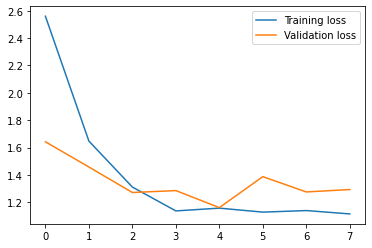

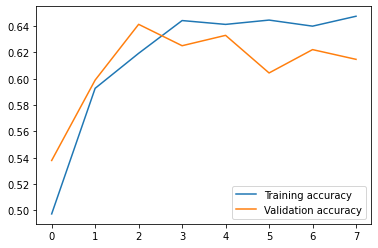

In [7]:
## Función que muestra la evolución de las accuracy de train y validacion
## durante el entrenamiento.
def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

## Vamos a entrenar usando la red EfficietNetB1
base_model = tf.keras.applications.EfficientNetB1(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/efficientnetb1_notop.h5',
                                               pooling='avg')

base_model.trainable = False

normalization = Rescaling(1./255)
prediction_layer = Dense(29, activation="softmax")

model = Sequential([
  #normalization,
  base_model,
  BatchNormalization(),
  Dropout(0.2),
  prediction_layer
])

opt = Adam(learning_rate=1e-2)
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("EfficientNetB1 con DataAugmentation (AdvProp), congelando red y solo aniadiendo capa de salida")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                    epochs=25,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

Epoch 1/10
258/258 [==============================] - 332s 1s/step - loss: 1.2362 - accuracy: 0.6298 - val_loss: 1.0943 - val_accuracy: 0.6788
Epoch 2/10
258/258 [==============================] - 310s 1s/step - loss: 0.6942 - accuracy: 0.7682 - val_loss: 0.8725 - val_accuracy: 0.7438
Epoch 3/10
258/258 [==============================] - 310s 1s/step - loss: 0.5666 - accuracy: 0.8084 - val_loss: 0.7559 - val_accuracy: 0.7911
Epoch 4/10
258/258 [==============================] - 310s 1s/step - loss: 0.4923 - accuracy: 0.8280 - val_loss: 0.6424 - val_accuracy: 0.8113
Epoch 5/10
258/258 [==============================] - 310s 1s/step - loss: 0.4138 - accuracy: 0.8575 - val_loss: 0.6844 - val_accuracy: 0.7941
Epoch 6/10
258/258 [==============================] - 311s 1s/step - loss: 0.3741 - accuracy: 0.8666 - val_loss: 0.7882 - val_accuracy: 0.7606
Epoch 7/10
258/258 [==============================] - 311s 1s/step - loss: 0.3594 - accuracy: 0.8751 - val_loss: 0.6692 - val_accuracy: 0.7970

2022/03/14 22:06:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


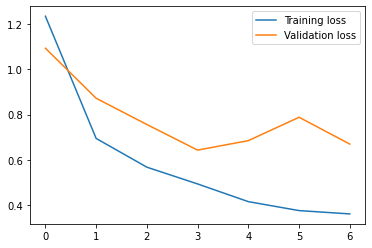

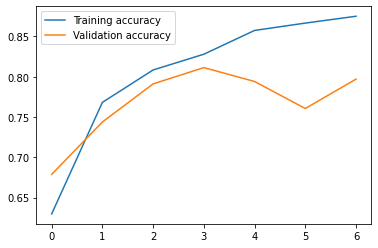

In [8]:
## FINE TUNING: Volvemos a entrenar descongelando algunas capas (menos las BatchNormalization)

def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    opt = Adam(learning_rate=1e-4)
    model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])


unfreeze_model(model)

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                    epochs=10,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

In [9]:
## Predecimos las clases
y_pred = model.predict(test)
classes = np.argmax(y_pred, axis=1)
classes = np.array(classes)
classes = classes + 1
print(classes)

[10 10 10 ... 11  9 24]


In [11]:
## Creamos el csv con los resultados
d = {'id.jpg': sorted(os.listdir("Sentinel2LULC_Test")), 'label': classes}
df = pd.DataFrame(data=d)
df.to_csv('EfficientNetB1_AdvProp.csv', index=False)
files.download('EfficientNetB1_AdvProp.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>